In [ ]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install osmnet
!pip install cs-brix
!pip install matplotlib==3.1.3
!pip install osmnet
!pip install pandana
!pip install folium

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/CityScope/CSL_HCMC.git

Cloning into 'CSL_HCMC'...
remote: Enumerating objects: 1957, done.
remote: Counting objects: 100% (617/617), done.
remote: Compressing objects: 100% (336/336), done.
remote: Total 1957 (delta 323), reused 515 (delta 275), pack-reused 1340
Receiving objects: 100% (1957/1957), 179.17 MiB | 22.32 MiB/s, done.
Resolving deltas: 100% (1000/1000), done.
Checking out files: 100% (542/542), done.


In [ ]:
from brix.grid_maker import Grid_maker
import geopandas as gpd
import json
import numpy as np

In [ ]:
path = "/content/drive/MyDrive/Cityscope_L3_SGP"
# path = "/content/CSL_HCMC"

In [ ]:
# s2_lu_interact=gpd.read_file(path + '/SGP_Scenario2/LandUse_Interactive.shp')
s2_lu_interact=gpd.read_file("./SDMC_District7/Data/4. Geojson file/landuse/LandUse_In.json")

In [ ]:
def abbreviate_type_name(name):
    """
    Shorter type names for CityScope UI"""
    return name.split(',')[0].split(' (')[0].replace('\n','').replace('\r','').strip()

#### Specify grid parameters

In [ ]:
### sgp_test
# table_name='sgp_scenario_'
# top_left_lon=106.738584
# top_left_lat=10.733957
# rotation=48
# cell_size=23
# ncols=96
# nrows=55

### spg_test2
# table_name='sgp_scenario_'
# top_left_lon=106.739840
# top_left_lat=10.739956
# rotation=3
# cell_size=23
# ncols=96
# nrows=55

### spg_test3
# table_name='sgp_scenario_'
# top_left_lon=106.739440
# top_left_lat=10.740904
# rotation=0
# cell_size=23
# ncols=96
# nrows=55

### v2 13.12.21
table_name='sgp_scenario_'
top_left_lon=106.739840
top_left_lat=10.739956
rotation=3
cell_size=23
ncols=96
nrows=55

#### Create grid object using cs-brix library

In [ ]:
grid=Grid_maker(table_name=table_name, top_left_lon=top_left_lon, top_left_lat=top_left_lat, 
                     rotation=rotation, cell_size=cell_size, ncols=ncols, nrows=nrows)

https://cityio.media.mit.edu/api/tables/list/ Attempt: 0
Calculating initial coordinates of each cell
Defining properties and headers


Generating grid geojson


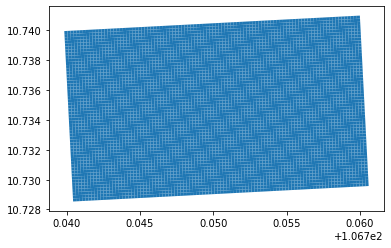

In [ ]:
grid_gpd=gpd.read_file(json.dumps(grid.get_grid_geojson()))
grid_gpd.plot()

#### Update default types to CSL_HCMC types

In [ ]:
import pandas
landtypes = pandas.read_csv('./Landtype.csv')
landtypes = landtypes.rename(columns={'NAICS_proportions':'NAICS_proportion'})
landtypes

,No.,CSLLandtype,LBCS,LBCS_proportion,NAICS,NAICS_proportion,Area per person (employee) (sqm/person),Area per person (resident) (sqm/person),Color
0,1,Residential - lowrise,"1100, 1110, 1210, 1220","0.5, 0.1, 0.2, 0.2",Null,Null,"0, 60, 60, 60","20, 20, 20, 20",#d2c700
1,2,Residential - highrise,1120,1,Null,Null,1200,25,#f5e200
2,3,"Commercial, Service","2100, 2200, 2300, 6500","0.1, 0.2, 0.5, 0.2","445110, 722110, 661114, 721110","0.1, 0.2, 0.5, 0.2","90, 13, 10, 100",0,#f28125
3,4,"Administrative, Public facility",2300,1,920000,1,10,0,#e30102
4,5,Industrial,3000,1,480000,1,30,0,#8900fe
5,6,Educational,"4100, 2500","0.95, 0.05","610000, 722500","0.95, 0.05","96, 13",0,#801f00
6,7,Healthcare,"6500, 2500","0.95, 0.05","620000, 722500","0.95, 0.05","58, 13",0,#ff00bf
7,8,"National defense, Security",4700,1,480000,1,46.5,0,#373b2a
8,9,"Transportation, Infrastructure",5000,1,480000,1,0,0,#fafafa
9,10,Religious,6600,1,710000,1,40,0,#4c0000


In [ ]:
from PIL import ImageColor
c = list(ImageColor.getcolor(landtypes['Color'][0], 'RGB'))
c.insert(3, 180)
print(landtypes['Color'][0])
print(c)

#d2c700
[76, 0, 0, 180]


In [ ]:
import random
import numpy as np
from PIL import ImageColor

def csv2json(typetable):
  types = {}
  typetable.insert(2, 'color', [[] for i in range(16)], True)
  print(typetable.columns)
  for index in range(len(typetable)):
      #print(types[index])
      row = typetable[index:index+1]
      print(row)
      row['CSLLandtype'] = row['CSLLandtype'].values[0].split(',')[0] #
      # if row['CSLLandtype'].values[0] == 'Residential - lowrise' or row['CSLLandtype'].values[0] == 'Residential - highrise':
      #   row['color'].values[0] = [255, 255, 0, 180]
      # else:
      #   row['color'].values[0] = types_old[row['CSLLandtype'].values[0]]['color'] #
      c = list(ImageColor.getcolor(row['Color'].values[0], 'RGB'))
      c.insert(3, 180)
      row['color'].values[0] = c
      land_type = row['CSLLandtype'].values[0]
      types[land_type] = {}
      types[land_type]['color'] = row['color'].values[0] #

      for attr in ['LBCS', 'NAICS']:
        types[land_type][attr] = {}
        codes = row[attr].values[0].split(', ')
        props = row[attr+'_proportion'].values[0].split(', ')
        sqm_pemp = row['Area per person (employee) (sqm/person)'].values[0].split(', ')
        sqm_pres = row['Area per person (resident) (sqm/person)'].values[0].split(', ')
        for idx, code in enumerate(codes):
          if code == 'Null':
            continue
          types[land_type][attr][code] = {}
          types[land_type][attr][code]['props'] = props[idx]
          if idx >= len(sqm_pemp):
            types[land_type][attr][code]['sqm_pemp'] = '0'
          else:
            types[land_type][attr][code]['sqm_pemp'] = sqm_pemp[idx]
          if idx >= len(sqm_pres):
            types[land_type][attr][code]['sqm_pres'] = '0'
          else:
            types[land_type][attr][code]['sqm_pres'] = sqm_pres[idx]
      
  return types

types = csv2json(landtypes)
types

Index(['No.', 'CSLLandtype', 'color', 'LBCS', 'LBCS_proportion', 'NAICS',
       'NAICS_proportion', 'Area per person (employee) (sqm/person)',
       'Area per person (resident) (sqm/person)', 'Color'],
      dtype='object')
   No.            CSLLandtype  ... Area per person (resident) (sqm/person)    Color
0    1  Residential - lowrise  ...                          20, 20, 20, 20  #d2c700

[1 rows x 10 columns]
   No.             CSLLandtype  ... Area per person (resident) (sqm/person)    Color
1    2  Residential - highrise  ...                                      25  #f5e200

[1 rows x 10 columns]
   No.          CSLLandtype  ... Area per person (resident) (sqm/person)    Color
2    3  Commercial, Service  ...                                       0  #f28125

[1 rows x 10 columns]
   No.  ...    Color
3    4  ...  #e30102

[1 rows x 10 columns]
   No. CSLLandtype  ... Area per person (resident) (sqm/person)    Color
4    5  Industrial  ...                                       0  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

{'Administrative': {'LBCS': {'2300': {'props': '1',
    'sqm_pemp': '10',
    'sqm_pres': '0'}},
  'NAICS': {'920000': {'props': '1', 'sqm_pemp': '10', 'sqm_pres': '0'}},
  'color': [227, 1, 2, 180]},
 'Commercial': {'LBCS': {'2100': {'props': '0.1',
    'sqm_pemp': '90',
    'sqm_pres': '0'},
   '2200': {'props': '0.2', 'sqm_pemp': '13', 'sqm_pres': '0'},
   '2300': {'props': '0.5', 'sqm_pemp': '10', 'sqm_pres': '0'},
   '6500': {'props': '0.2', 'sqm_pemp': '100', 'sqm_pres': '0'}},
  'NAICS': {'445110': {'props': '0.1', 'sqm_pemp': '90', 'sqm_pres': '0'},
   '661114': {'props': '0.5', 'sqm_pemp': '10', 'sqm_pres': '0'},
   '721110': {'props': '0.2', 'sqm_pemp': '100', 'sqm_pres': '0'},
   '722110': {'props': '0.2', 'sqm_pemp': '13', 'sqm_pres': '0'}},
  'color': [242, 129, 37, 180]},
 'Educational': {'LBCS': {'2500': {'props': '0.05',
    'sqm_pemp': '13',
    'sqm_pres': '0'},
   '4100': {'props': '0.95', 'sqm_pemp': '96', 'sqm_pres': '0'}},
  'NAICS': {'610000': {'props': '0.95', '

#### Specify which cells are interactive
interactive.geojson is a rough outline of the nteractive region of the site, created using geojson.io. Should be updated if it is nt accurate enough

In [ ]:
interactive=gpd.read_file('./SDMC_District7/Data/4. Geojson file/landuse/LandUse_In.json')
# interactive=interactive.to_crs("EPSG:4326")
grid_gpd=gpd.read_file(json.dumps(grid.get_grid_geojson()))
interactive_over_grid=gpd.overlay(grid_gpd, interactive, how='intersection')
int_cell_ids=grid_gpd['id'].unique()
int_cell_ids

array([   0,    1,    2, ..., 5277, 5278, 5279])

In [ ]:
interact_cell_ids=interactive_over_grid['id_1'].unique()
len(interact_cell_ids)


2377

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


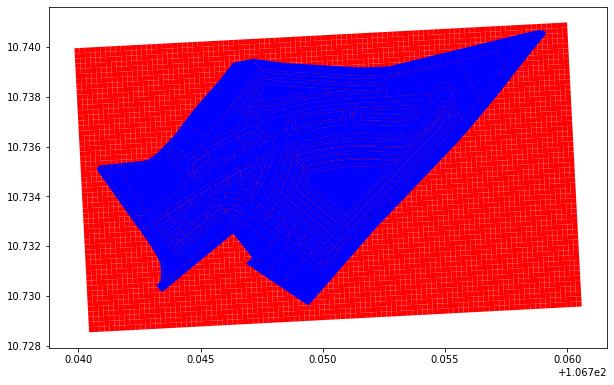

In [ ]:
centroids=grid_gpd.geometry.centroid
grid_gpd['x_centroid']=[c.x for c in centroids]
grid_gpd['y_centroid']=[c.y for c in centroids]

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,figsize=(10,10))
grid_gpd.plot(ax=ax, color='red')
s2_lu_interact.to_crs("EPSG:4326").plot(ax=ax, color='blue')

#### Create the three GEOGRID and GEOGRIDDATA files

In [ ]:
# lu_files={0: s0_lu, 2: s2_lu, 3: s3_lu}
lu_files={2: s2_lu_interact}
scenario_grids={}

In [ ]:
lu_over_grid

,TypeCode,LandUseTyp,Storey,CSLLandTyp,Shape_Leng,Shape_Area,height_1,id_1,fill,ShapeArea,height_2,id_2,interactive,name,geometry,area
1819,NNO,Villa,5.0,Residential - lowrise,0.026798,2.396448e-06,17.5,232,#d2c700,28998.505621,0,2752,Web,test,"POLYGON ((106.75358 10.73483, 106.75358 10.734...",4.424379e-15
1122,CXDT,Buffer Green,0.0,"Open space, Greenery, Park",0.040543,8.847187e-06,0.0,26,#52a401,107056.000916,0,743,Web,test,"POLYGON ((106.75482 10.73927, 106.75482 10.739...",4.783825e-15
2014,NNO,Shophouse,5.0,Residential - lowrise,0.002352,1.972076e-07,17.5,155,#d2c700,2386.315755,0,2339,Web,test,"POLYGON ((106.74746 10.73514, 106.74746 10.735...",1.120374e-14
2955,NNO,Villa,5.0,Residential - lowrise,0.001335,9.222920e-08,17.5,168,#d2c700,1116.011114,0,1281,Web,test,"POLYGON ((106.74698 10.73762, 106.74698 10.737...",1.421629e-14
1877,CXDT,Greenery,0.0,"Open space, Greenery, Park",0.009494,5.364555e-07,0.0,51,#52a401,6491.401422,0,2808,Web,test,"POLYGON ((106.74542 10.73400, 106.74542 10.734...",5.816354e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912,CXDT,Buffer Green,0.0,"Open space, Greenery, Park",0.003358,6.176131e-07,0.0,16,#52a401,7473.308602,0,1670,Web,test,"POLYGON ((106.74821 10.73685, 106.74823 10.736...",4.371814e-08
911,CXDT,Buffer Green,0.0,"Open space, Greenery, Park",0.003358,6.176131e-07,0.0,16,#52a401,7473.308602,0,1669,Web,test,"POLYGON ((106.74800 10.73684, 106.74802 10.736...",4.371814e-08
899,CXDT,Buffer Green,0.0,"Open space, Greenery, Park",0.003358,6.176131e-07,0.0,16,#52a401,7473.308602,0,1575,Web,test,"POLYGON ((106.74841 10.73707, 106.74842 10.736...",4.371814e-08
780,GD,Education,0.0,Educational,0.008149,3.679264e-06,0.0,13,#801f00,44520.865866,0,2607,Web,test,"POLYGON ((106.74349 10.73452, 106.74351 10.734...",4.371814e-08


In [ ]:
grid_to_type

In [ ]:
import copy
for s in lu_files:
    print(s)
    scenario_lu=lu_files[s]
    scenario_lu_wgs=scenario_lu.to_crs("EPSG:4326")
    grid_geojson=copy.deepcopy(grid.get_grid_geojson())
    grid_gpd=gpd.read_file(json.dumps(grid_geojson))
    lu_over_grid=gpd.overlay(scenario_lu_wgs, grid_gpd, 'intersection')   

    grid_to_type={}
    lu_over_grid['area']=lu_over_grid.geometry.area
    lu_over_grid=lu_over_grid.sort_values('area', ascending=True)
    for ind, row in lu_over_grid.iterrows():
        # print(row)
        grid_to_type[row['id_2']]={'type': abbreviate_type_name(row['CSLLandTyp']), 'height': int(row['Storey'])}

    geogriddata=[]
    count=0
    for i_c, cell in enumerate(grid_geojson['features']):
        assert i_c==cell['properties']['id']
        if cell['properties']['id'] not in grid_to_type:
            # print("test.", cell['properties']['id'])
            cs_type="None"
            height=0
            count+=1
        else:
            cs_type=grid_to_type[i_c]['type']
            height=grid_to_type[i_c]['height']
        if cell['properties']['id'] in interact_cell_ids:
            is_interactive=True # 'Web' in the default version
        else:
            is_interactive=False
        # print(cs_type)
        # print(types[cs_type])
        if cs_type == "None":
            color=[0, 70, 255, 0]
        else:    
            color=types[cs_type]['color']
            # print(color)

        # if is_interactive==False:
        #     color[3]=0
        # else:
        #     color[3]=200
        grid_geojson['features'][i_c]['properties']['interactive']=is_interactive
        grid_geojson['features'][i_c]['properties']['color']=color
        grid_geojson['features'][i_c]['properties']['name']=cs_type
        grid_geojson['features'][i_c]['properties']['height']=height

        geogriddata.append({'color': color, 'height': height, 'id': i_c, 'name': cs_type, 'interactive': is_interactive})
    scenario_grids[s]={'geogrid': grid_geojson, 'geogriddata': geogriddata}
print(count)

In [ ]:
a = []
for i in range(len(scenario_grids[2]['geogriddata'])):
  a.append(scenario_grids[2]['geogriddata'][i]['interactive'])
print(len(a))
print(np.unique(a))
print(a[200])
c = 0
for i in range(len(a)):
  if a[i] == 'Web':
    c+=1
c

5280
[False  True]
False


0

#### Save the results

In [ ]:
!mkdir '/content/sgp_scenario_2'
path2 = "/content/sgp_scenario_2"
for s in scenario_grids:
    json.dump(scenario_grids[s]['geogrid'], open(path2 + '/geogrid_scenario_{}.geojson'.format(s), 'a+'))
    json.dump(scenario_grids[s]['geogriddata'], open(path2 + '/geogrid_data_scenario_{}.json'.format(s), 'a+'))

In [ ]:
# !rm -r /content/sgp_scenario_2

In [ ]:
f = open("/content/type_edit_grid.json")
type_edit_grid = json.load(f)
type_edit_grid

In [ ]:
scenario_grids[2]['geogrid']['properties']['types'] = type_edit_grid

In [ ]:
f1 = open("./SDMC_District7/Data/4. Geojson file/landuse/LandUse_Erase_In.json")
landuse_ = json.load(f1)

# with PORT interact area

In [ ]:
from brix.grid_maker import Grid_maker
import geopandas as gpd
import json
import numpy as np

In [ ]:
path = "/content/drive/MyDrive/Cityscope_L3_SGP"
# path = "/content/CSL_HCMC"

In [ ]:
# s2_lu_interact=gpd.read_file(path + '/SGP_Scenario2/LandUse_Interactive.shp')
s2_lu_interact=gpd.read_file("./SDMC_District7/Data/4. Geojson file/landuse/LandUse_In.json")
port_interact=gpd.read_file("./SDMC_District7/Data/4. Geojson file/landuse/Port.json")

In [ ]:
def abbreviate_type_name(name):
    """
    Shorter type names for CityScope UI"""
    return name.split(',')[0].split(' (')[0].replace('\n','').replace('\r','').strip()

#### Specify grid parameters

In [ ]:
### sgp_test
# table_name='sgp_scenario_'
# top_left_lon=106.738584
# top_left_lat=10.733957
# rotation=48
# cell_size=23
# ncols=96
# nrows=55

### spg_test2
# table_name='sgp_scenario_'
# top_left_lon=106.739840
# top_left_lat=10.739956
# rotation=3
# cell_size=23
# ncols=96
# nrows=55

### spg_test3
# table_name='sgp_scenario_'
# top_left_lon=106.739440
# top_left_lat=10.740904
# rotation=0
# cell_size=23
# ncols=96
# nrows=55

### v2 13.12.21
# table_name='sgp_scenario_'
# top_left_lon=106.739840
# top_left_lat=10.739956
# rotation=3
# cell_size=23
# ncols=96
# nrows=55

table_name='sgp_scenario_'
top_left_lon=106.739936
top_left_lat=10.742484
rotation=3.5
cell_size=23
ncols=105
nrows=75

#### Create grid object using cs-brix library

In [ ]:
grid=Grid_maker(table_name=table_name, top_left_lon=top_left_lon, top_left_lat=top_left_lat, 
                     rotation=rotation, cell_size=cell_size, ncols=ncols, nrows=nrows)

https://cityio.media.mit.edu/api/tables/list/ Attempt: 0
Calculating initial coordinates of each cell
Defining properties and headers


Generating grid geojson


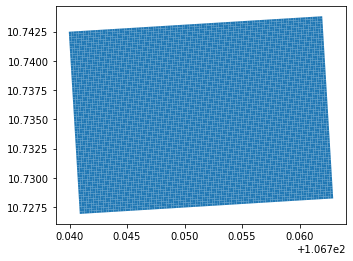

In [ ]:
grid_gpd=gpd.read_file(json.dumps(grid.get_grid_geojson()))
grid_gpd.plot()

#### Update default types to CSL_HCMC types

In [ ]:
import pandas
landtypes = pandas.read_csv('./Landtype.csv')
landtypes = landtypes.rename(columns={'NAICS_proportions':'NAICS_proportion'})
landtypes

,No.,CSLLandtype,LBCS,LBCS_proportion,NAICS,NAICS_proportion,Area per person (employee) (sqm/person),Area per person (resident) (sqm/person),Color
0,1,Residential - lowrise,"1100, 1110, 1210, 1220","0.5, 0.1, 0.2, 0.2",Null,Null,"0, 60, 60, 60","20, 20, 20, 20",#d2c700
1,2,Residential - highrise,1120,1,Null,Null,1200,25,#f5e200
2,3,"Commercial, Service","2100, 2200, 2300, 6500","0.1, 0.2, 0.5, 0.2","445110, 722110, 661114, 721110","0.1, 0.2, 0.5, 0.2","90, 13, 10, 100",0,#f28125
3,4,"Administrative, Public facility",2300,1,920000,1,10,0,#e30102
4,5,Industrial,3000,1,480000,1,30,0,#8900fe
5,6,Educational,"4100, 2500","0.95, 0.05","610000, 722500","0.95, 0.05","96, 13",0,#801f00
6,7,Healthcare,"6500, 2500","0.95, 0.05","620000, 722500","0.95, 0.05","58, 13",0,#ff00bf
7,8,"National defense, Security",4700,1,480000,1,46.5,0,#373b2a
8,9,"Transportation, Infrastructure",5000,1,480000,1,0,0,#fafafa
9,10,Religious,6600,1,710000,1,40,0,#4c0000


In [ ]:
from PIL import ImageColor
c = list(ImageColor.getcolor(landtypes['Color'][0], 'RGB'))
c.insert(3, 180)
print(landtypes['Color'][0])
print(c)

#d2c700
[76, 0, 0, 180]


In [ ]:
import random
import numpy as np
from PIL import ImageColor

def csv2json(typetable):
  types = {}
  typetable.insert(2, 'color', [[] for i in range(16)], True)
  print(typetable.columns)
  for index in range(len(typetable)):
      #print(types[index])
      row = typetable[index:index+1]
      print(row)
      row['CSLLandtype'] = row['CSLLandtype'].values[0].split(',')[0] #
      # if row['CSLLandtype'].values[0] == 'Residential - lowrise' or row['CSLLandtype'].values[0] == 'Residential - highrise':
      #   row['color'].values[0] = [255, 255, 0, 180]
      # else:
      #   row['color'].values[0] = types_old[row['CSLLandtype'].values[0]]['color'] #
      c = list(ImageColor.getcolor(row['Color'].values[0], 'RGB'))
      c.insert(3, 180)
      row['color'].values[0] = c
      land_type = row['CSLLandtype'].values[0]
      types[land_type] = {}
      types[land_type]['color'] = row['color'].values[0] #

      for attr in ['LBCS', 'NAICS']:
        types[land_type][attr] = {}
        codes = row[attr].values[0].split(', ')
        props = row[attr+'_proportion'].values[0].split(', ')
        sqm_pemp = row['Area per person (employee) (sqm/person)'].values[0].split(', ')
        sqm_pres = row['Area per person (resident) (sqm/person)'].values[0].split(', ')
        for idx, code in enumerate(codes):
          if code == 'Null':
            continue
          types[land_type][attr][code] = {}
          types[land_type][attr][code]['props'] = props[idx]
          if idx >= len(sqm_pemp):
            types[land_type][attr][code]['sqm_pemp'] = '0'
          else:
            types[land_type][attr][code]['sqm_pemp'] = sqm_pemp[idx]
          if idx >= len(sqm_pres):
            types[land_type][attr][code]['sqm_pres'] = '0'
          else:
            types[land_type][attr][code]['sqm_pres'] = sqm_pres[idx]
      
  return types

types = csv2json(landtypes)
types

#### Specify which cells are interactive
interactive.geojson is a rough outline of the nteractive region of the site, created using geojson.io. Should be updated if it is nt accurate enough

In [ ]:
interactive=gpd.read_file('./SDMC_District7/Data/4. Geojson file/landuse/LandUse_In.json')
# interactive=interactive.to_crs("EPSG:4326")
grid_gpd=gpd.read_file(json.dumps(grid.get_grid_geojson()))
interactive_over_grid=gpd.overlay(grid_gpd, interactive, how='intersection')
int_cell_ids=grid_gpd['id'].unique()
int_cell_ids

array([   0,    1,    2, ..., 7872, 7873, 7874])

In [ ]:
port_interactive=port_interact
grid_gpd2=gpd.read_file(json.dumps(grid.get_grid_geojson()))
interactive_over_grid2=gpd.overlay(grid_gpd2, port_interactive, how='intersection')
int_cell_ids2=grid_gpd2['id'].unique()
int_cell_ids2

array([   0,    1,    2, ..., 7872, 7873, 7874])

In [ ]:
len(interactive_over_grid)

4973

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


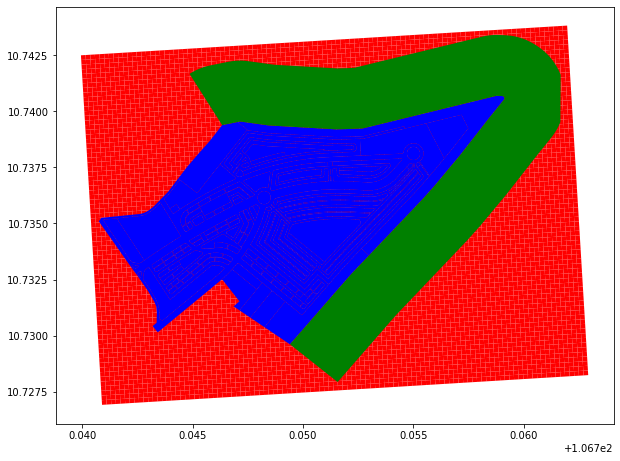

In [ ]:
centroids=grid_gpd.geometry.centroid
grid_gpd['x_centroid']=[c.x for c in centroids]
grid_gpd['y_centroid']=[c.y for c in centroids]

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,figsize=(10,10))
grid_gpd.plot(ax=ax, color='red')
interactive.plot(ax=ax, color='blue')
port_interact.plot(ax=ax, color='green')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


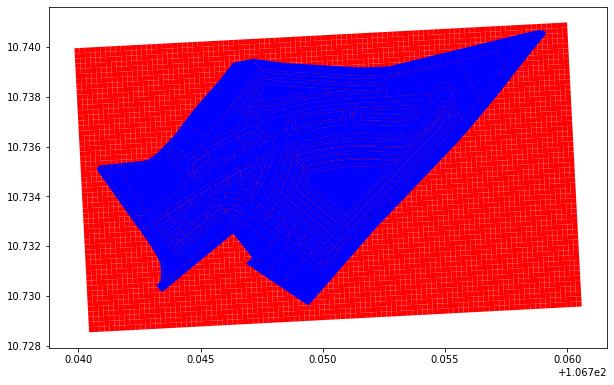

In [ ]:
centroids=grid_gpd.geometry.centroid
grid_gpd['x_centroid']=[c.x for c in centroids]
grid_gpd['y_centroid']=[c.y for c in centroids]

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,figsize=(10,10))
grid_gpd.plot(ax=ax, color='red')
s2_lu_interact.to_crs("EPSG:4326").plot(ax=ax, color='blue')

#### Create the three GEOGRID and GEOGRIDDATA files

In [ ]:
# lu_files={0: s0_lu, 2: s2_lu, 3: s3_lu}
lu_files={2: s2_lu_interact}
scenario_grids={}

In [ ]:
lu_over_grid

In [ ]:
grid_to_type

In [ ]:
import copy
for s in lu_files:
    print(s)
    scenario_lu=lu_files[s]
    scenario_lu_wgs=scenario_lu.to_crs("EPSG:4326")
    grid_geojson=copy.deepcopy(grid.get_grid_geojson())
    grid_gpd=gpd.read_file(json.dumps(grid_geojson))
    lu_over_grid=gpd.overlay(scenario_lu_wgs, grid_gpd, 'intersection')   

    grid_to_type={}
    lu_over_grid['area']=lu_over_grid.geometry.area
    lu_over_grid=lu_over_grid.sort_values('area', ascending=True)
    for ind, row in lu_over_grid.iterrows():
        # print(row)
        grid_to_type[row['id_2']]={'type': abbreviate_type_name(row['CSLLandTyp']), 'height': int(row['Storey'])}

    geogriddata=[]
    count=0
    for i_c, cell in enumerate(grid_geojson['features']):
        assert i_c==cell['properties']['id']
        if cell['properties']['id'] not in grid_to_type:
            # print("test.", cell['properties']['id'])
            cs_type="None"
            height=0
            count+=1
        else:
            cs_type=grid_to_type[i_c]['type']
            height=grid_to_type[i_c]['height']
        if cell['properties']['id'] in interact_cell_ids:
            is_interactive=True # 'Web' in the default version
        else:
            is_interactive=False

        # print(cs_type)
        # print(types[cs_type])

        if cs_type == "None":
            color=[0, 70, 255, 0]
        if cs_type == "None" and cell['properties']['id'] in interact_cell_ids2:
            is_interactive=True
            color=[109, 167, 176, 150]
        elif cs_type != "None":
            color=types[cs_type]['color']
            # print(color)

        # if is_interactive==False:
        #     color[3]=0
        # else:
        #     color[3]=200
        grid_geojson['features'][i_c]['properties']['interactive']=is_interactive
        grid_geojson['features'][i_c]['properties']['color']=color
        grid_geojson['features'][i_c]['properties']['name']=cs_type
        grid_geojson['features'][i_c]['properties']['height']=height

        geogriddata.append({'color': color, 'height': height, 'id': i_c, 'name': cs_type, 'interactive': is_interactive})
    scenario_grids[s]={'geogrid': grid_geojson, 'geogriddata': geogriddata}
print(count)

2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # This is added back by InteractiveShellApp.init_path()


5495


In [ ]:
a = []
for i in range(len(scenario_grids[2]['geogriddata'])):
  a.append(scenario_grids[2]['geogriddata'][i]['interactive'])
print(len(a))
print(np.unique(a))
print(a[200])
c = 0
for i in range(len(a)):
  if a[i] == 'Web':
    c+=1
c

7875
[False  True]
False


0

#### Save the results

In [ ]:
f = open("/content/type_edit_grid.json")
type_edit_grid = json.load(f)
# type_edit_grid

In [ ]:
scenario_grids[2]['geogrid']['properties']['types'] = type_edit_grid

In [ ]:
f1 = open("./SDMC_District7/Data/4. Geojson file/landuse/LandUse_Erase_In_Port.json")
landuse_ = json.load(f1)

In [ ]:
!mkdir '/content/sgp_scenario_2'
path2 = "/content/sgp_scenario_2"
for s in scenario_grids:
    json.dump(scenario_grids[s]['geogrid'], open(path2 + '/geogrid_scenario_{}.geojson'.format(s), 'a+'))
    json.dump(scenario_grids[s]['geogriddata'], open(path2 + '/geogrid_data_scenario_{}.json'.format(s), 'a+'))

In [ ]:
!rm -r /content/sgp_scenario_2